In [31]:
import pandas as pd 
import requests 
import json 
import matplotlib.pyplot as plt
import re
from glob import glob
import spacy
import numpy as np
from datetime import datetime
import time
import altair as alt
%matplotlib inline

## Load the data in from the prased json files

In [2]:
def load_all():
    columns = ["Date","Agency",'Subject','Message Sent']
    combined_data = pd.DataFrame(columns=columns)
    
    for f in glob("data/*.json"):
        if("package" in f):
            next
        with open(f) as json_file:
            data = json.load(json_file)
            combined_data = combined_data.append(pd.DataFrame(data , columns= ["Date","Agency",'Subject','Message Sent']))
    combined_data['Date'] = pd.to_datetime(combined_data['Date'], format='%m/%d/%Y %I:%M:%S %p')
    return combined_data
data = load_all()

In [4]:
data.Agency.unique()

array(['LIRR', 'BAT', 'NYC', 'NYTB', 'MNR', 'NYCT'], dtype=object)

In [19]:
data.sample(10)

## Assign extra variables (using regex and heuristics just now)

In [20]:
equipment_no_regex = re.compile(r'(E[S|L]\d{2,3}X?)')

def equipment_type(equipment_id):
    if(equipment_id and type(equipment_id)==str):
        first_two_letters = equipment_id[0:2]
        return "elevator" if  first_two_letters=="EL" else "escalator" if first_two_letters=='ES' else 'unknown'
    else:
        return 'unknown'
    
    
planned_dates_regex = re.compile(r"begin at(.*) and end by(.*)\. We")
def detect_planned_start_end_times(planned_message):
    try:
        groups = planned_dates_regex.search(planned_message).groups()
    except:
        print(planned_message)
    return pd.Series({ 'planned_start_time':pd.to_datetime(groups[0].strip(), format="%A, %B %d, %Y %I:%M %p"),
             'planned_end_time':pd.to_datetime(groups[1].strip(), format="%A, %B %d, %Y %I:%M %p")})


data = (data.assign( equipment_no_from_subject =  data.Subject.str.extract(equipment_no_regex), 
                    equipment_no_from_message = data['Message Sent'].str.extract(equipment_no_regex),
                    outage = ( (data['Subject'].str.lower().str.contains('outage') |  data['Subject'].str.lower().str.contains('out of service')) &  (~data['Subject'].str.lower().str.contains('details'))),
                    back_in_service = (data['Subject'].str.lower().str.contains('back in service') | data['Subject'].str.lower().str.contains('return to service')),
                    planned_outage  = (data['Subject'].str.lower().str.contains('outage planned')),
                    planned_start_time = None,
                    planned_end_time = None
                   )
            .assign(equipment_type  = lambda x : x.equipment_no_from_message.apply(equipment_type),
                    alert_type = 'other'
                 ))

data.loc[ data.outage, 'alert_type'] = 'outage'
data.loc[ data.back_in_service, 'alert_type'] = 'restore'
data.loc[ data.planned_outage, 'alert_type'] = 'planned'

planned_times = data.loc[data.planned_outage, "Message Sent"].apply(detect_planned_start_end_times)
data.loc[ data.planned_outage, 'planned_start_date'] = planned_times['planned_start_time']
data.loc[ data.planned_outage, 'planned_end_date'] = planned_times['planned_end_time']


## Extract station names ( we can get this from somewhere else but for now I think this is ok)

In [21]:
location_re = re.compile(r"\bat(.*)is\b")
equipment_dict = {}
for equipment_id in data.equipment_no_from_message[~data.equipment_no_from_message.isna()].unique():
    if(equipment_id):
        station_guesses = data[data.equipment_no_from_message==equipment_id].Subject.str.extract(location_re)[0].value_counts()
        if(len(station_guesses)>0):
            equipment_dict[equipment_id] = station_guesses.index[0].strip()
        else:
            equipment_dict[equipment_id] = None
with open("equipment_dictionary.json", 'w') as f:
    json.dump(equipment_dict,f)

Assign the guessed station name to the data frame

In [22]:
data=data.assign(station_name = lambda x : x.equipment_no_from_message.apply(lambda x:  equipment_dict[x] if x in equipment_dict.keys() else None))

## Write the data frame to disk

In [23]:
data.to_csv('data/all_alerts.csv.gz',index=False)

## Make some plots

Text(0.5, 1.0, 'All Alerts')

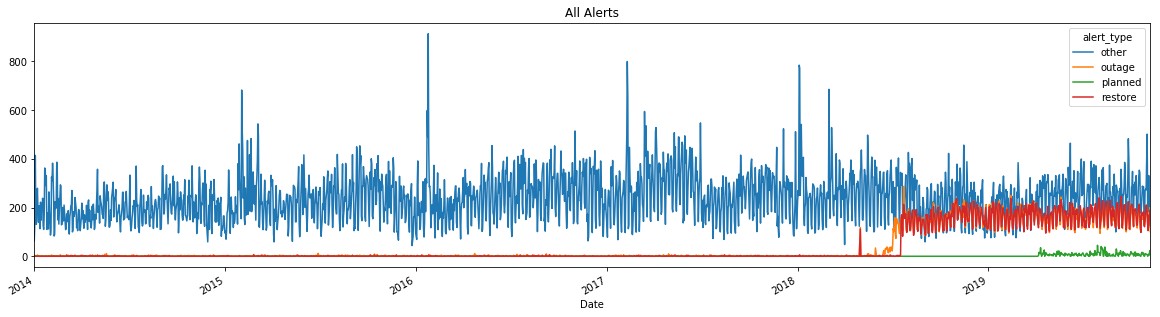

In [36]:
def plot_time_series(df,category=None):
    if(category):
        return (df.groupby([category, df.Date.dt.floor('d')])
            .count()
            .drop(['Date'],axis=1)
            .reset_index()
            .pivot_table(columns=category,index='Date',values='Agency' )
            .fillna(0)
            .plot(figsize=(20,5)))
    else:
        return df.groupby(df.Date.dt.floor('d')).count().elevator.plot()
        
ax = plot_time_series(data,category='alert_type')
ax.set_title("All Alerts")

Text(0.5, 1.0, 'Escalators')

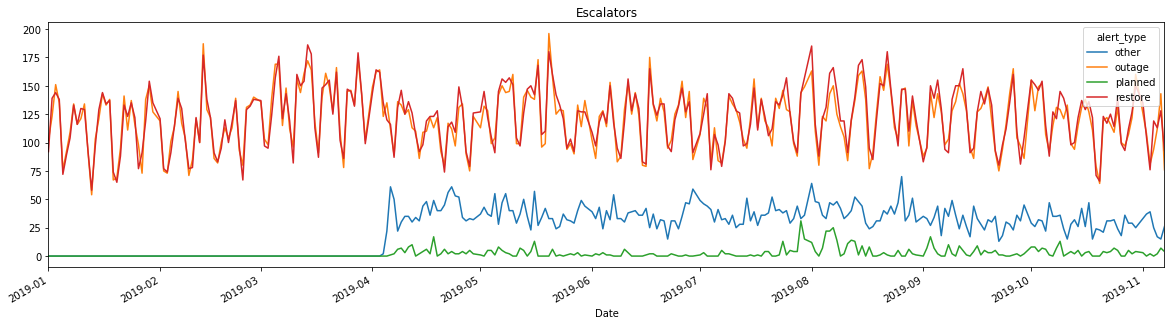

In [37]:
ax = plot_time_series(data[ (data.equipment_type=='escalator') & (data.Date.dt.year==2019) ],category='alert_type')
ax.set_title("Escalators")

Text(0.5, 1.0, 'Elevators')

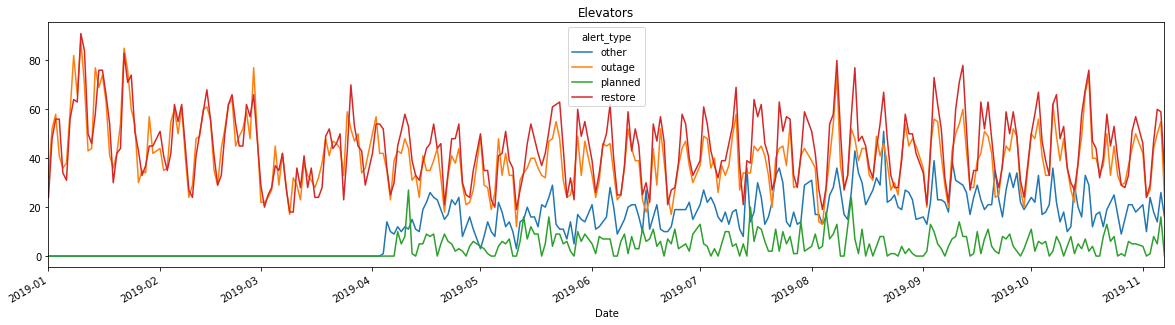

In [38]:
ax = plot_time_series(data[(data.equipment_type=='elevator') & (data.Date.dt.year==2019)],category='alert_type')
ax.set_title("Elevators")

## Most alerts by Equipment

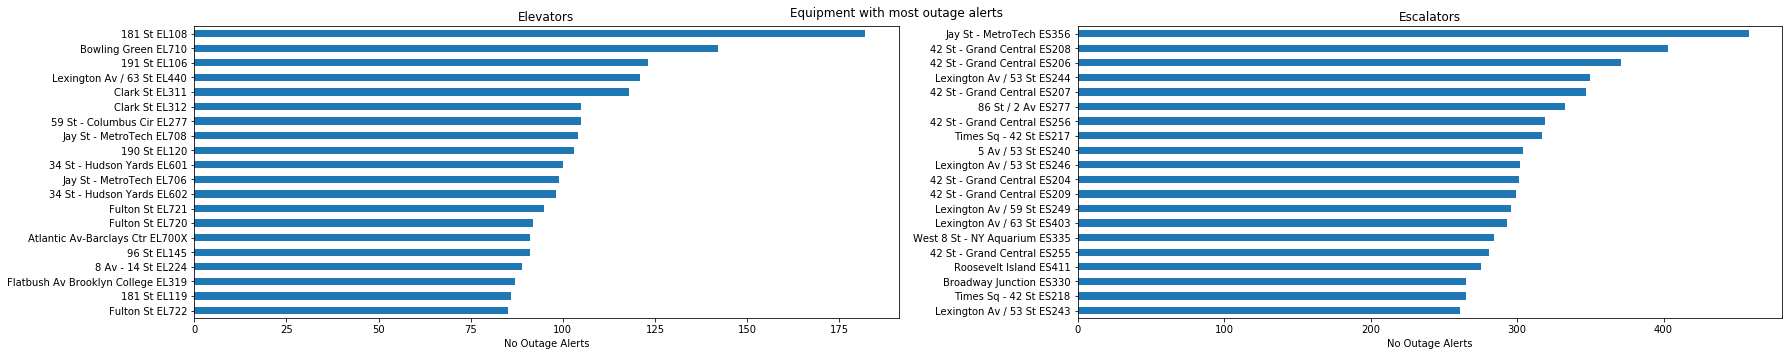

In [39]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25,5))

data_2019 = data[data.Date.dt.year==2019]
data_2019 = data_2019.assign(name_and_eid = data_2019.station_name + " " +  data_2019.equipment_no_from_message)
data_2019[data_2019.outage & (data_2019.equipment_type=='elevator')].groupby("name_and_eid").count().Date.sort_values(ascending=True).tail(20).plot(kind='barh', ax=axs[0])
data_2019[data_2019.outage & (data_2019.equipment_type=='escalator')].groupby("name_and_eid").count().Date.sort_values(ascending=True).tail(20).plot(kind='barh',ax=axs[1])

axs[0].set_title("Elevators")
axs[1].set_title("Escalators")

axs[0].set_xlabel("No Outage Alerts")
axs[1].set_xlabel("No Outage Alerts")

axs[0].set_ylabel('')
axs[1].set_ylabel('')
plt.suptitle('Equipment with most outage alerts')
plt.tight_layout()

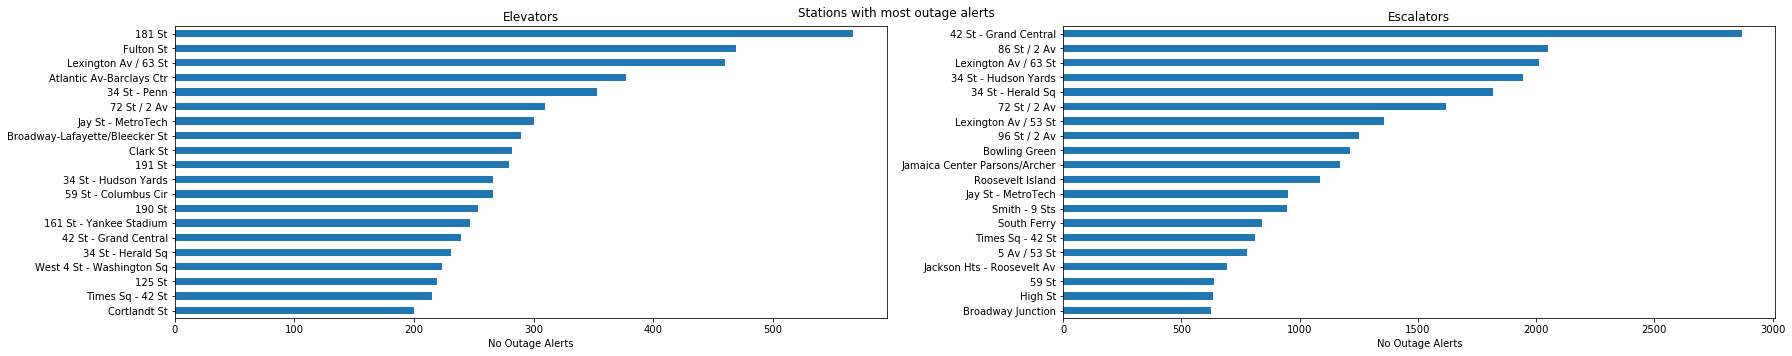

In [40]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25,5))

data_2019[data_2019.outage & (data_2019.equipment_type=='elevator')].groupby("station_name").count().Date.sort_values(ascending=True).tail(20).plot(kind='barh', ax=axs[0])
data_2019[data_2019.outage & (data_2019.equipment_type=='escalator')].groupby("station_name").count().Date.sort_values(ascending=True).tail(20).plot(kind='barh',ax=axs[1])

axs[0].set_title("Elevators")
axs[1].set_title("Escalators")

axs[0].set_xlabel("No Outage Alerts")
axs[1].set_xlabel("No Outage Alerts")

axs[0].set_ylabel('')
axs[1].set_ylabel('')
plt.suptitle('Stations with most outage alerts')
plt.tight_layout()

## Generate Outage event stats

In [41]:
def calc_outages_for_station(df):
    alert = df.sort_values("Date")
    next_alert = alert.shift(-1)
    
    outages = alert.assign(next_alert_time = next_alert.Date, next_alert_type= next_alert.alert_type, duration_h = (next_alert.Date - alert.Date).dt.seconds/60/60)
    # If the outage was planned use the reported start time rather than the message time
    planned_outages = outages.loc[outages.alert_type=='planned']
    planned_outages_duration = (planned_outages.next_alert_time - planned_outages.planned_start_date).dt.seconds/60/60
    outages.loc[outages.alert_type=='planned', 'duration_h'] = planned_outages_duration
    outages = outages.assign(next_alert_subject=next_alert['Subject'], next_alert_message=next_alert['Message Sent'])
    return outages[( (outages.alert_type=='outage') | (outages.alert_type=='planned')) & (outages.next_alert_type=='restore')]

In [42]:
outages = data_2019[data_2019.alert_type != 'other'].groupby('equipment_no_from_message').apply(calc_outages_for_station).reset_index(drop=True)

In [43]:
outage_stats_by_equipment = outages.groupby("equipment_no_from_message").duration_h.agg(['count',np.sum,np.mean,np.median,np.std]).sort_values('sum', ascending=False)

In [44]:
outage_stats_elevators = outage_stats_by_equipment[outage_stats_by_equipment.assign(equipment_no_from_message=outage_stats_by_equipment.index).equipment_no_from_message.apply(equipment_type)=='elevator']
outage_stats_escalators = outage_stats_by_equipment[outage_stats_by_equipment.assign(equipment_no_from_message=outage_stats_by_equipment.index).equipment_no_from_message.apply(equipment_type)=='escalator']

Text(0.5, 0, '% of time out of service')

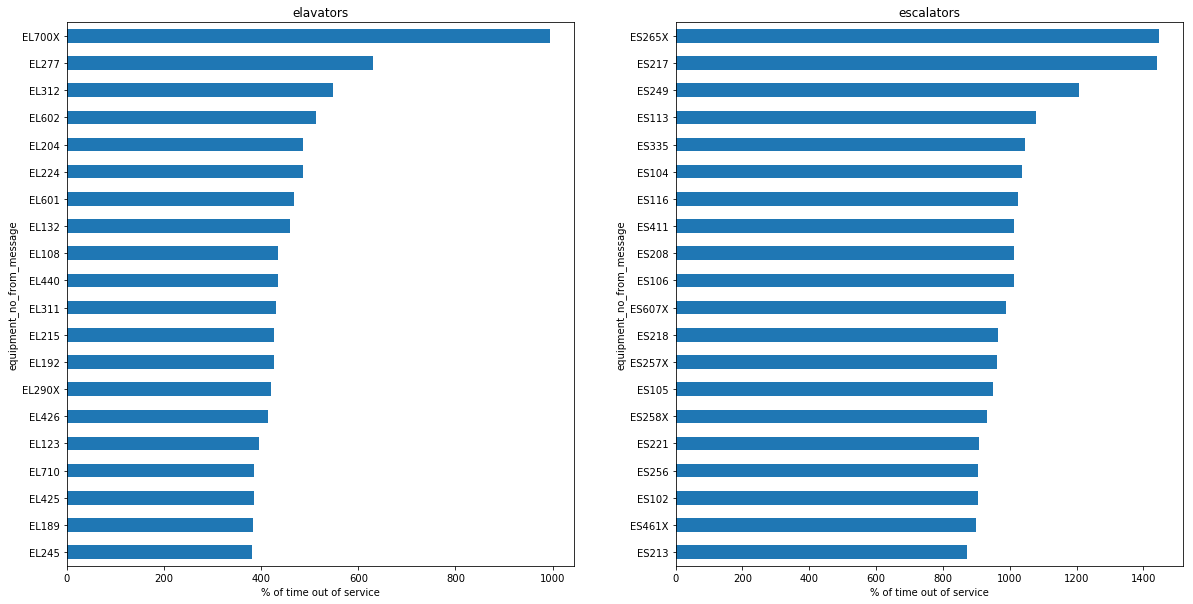

In [50]:
fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
outage_stats_elevators.sort_values('sum',ascending=True).tail(20)['sum'].plot(kind='barh', ax=axs[0],title='elavators')
outage_stats_escalators.sort_values('sum',ascending=True).tail(20)['sum'].plot(kind='barh', ax=axs[1],title='escalators')

axs[0].set_xlabel("% of time out of service")
axs[1].set_xlabel("% of time out of service")

In [46]:
long_data = (outages.groupby(['equipment_no_from_message',outages.Date.dt.floor('d')])
                    .duration_h.sum()
                    .reset_index()
                    .assign(day = lambda x: x.Date.dt.day, month = lambda x: x.Date.dt.month)
                    .set_index('equipment_no_from_message'))

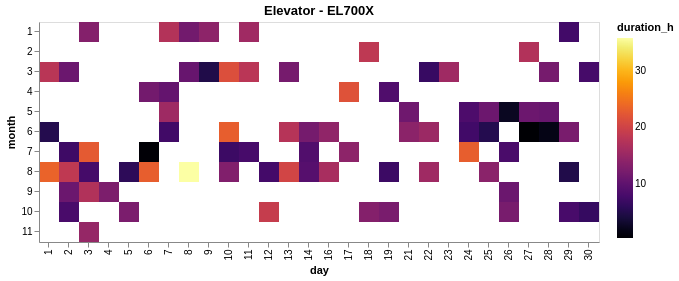

In [51]:
def heat_chart_for_equipment(equipment_id):
    return alt.Chart(long_data.loc[equipment_id], title="{} - {}".format( 'Escalator' if 'ES' in equipment_id else "Elevator", equipment_id )).mark_rect().encode(
      x='day:O',
      y='month:O',
      color=alt.Color('duration_h', scale=alt.Scale(scheme="inferno")),
    #   stroke=alt.Color('rgab(255,255,255,1)'),
      tooltip=[
        alt.Tooltip('duration_h',title="duration"),
        alt.Tooltip('day',title="day"),
        alt.Tooltip('month',title="month")
      ]
    ).configure_mark(strokeWidth=0)
heat_chart_for_equipment('EL700X')

In [ ]:
data_2019[data_2019['Subject'].str.contains('planned')].sample(20)["Message Sent"].values

In [ ]:
altair.Chart(long_data).mark_rect

In [ ]:
data_2019[ (data_2019.equipment_no_from_message=="ES265X") & 
           (data_2019.Date.dt.month ==6) & 
           ( (data_2019.Date.dt.day==30) | (data_2019.Date.dt.day==30) )].sort_values("Date")

In [60]:
outages[ (outages.equipment_no_from_message=="ES265X") & 
           (outages.Date.dt.month ==6) & 
           ( (outages.Date.dt.day==9))].sort_values("Date")

,Date,Agency,Subject,Message Sent,equipment_no_from_subject,equipment_no_from_message,outage,back_in_service,planned_outage,planned_start_time,...,alert_type,planned_start_date,planned_end_date,station_name,name_and_eid,next_alert_time,next_alert_type,duration_h,next_alert_subject,next_alert_message
25560,2019-06-09 00:55:03,NYC,Escalator outage at Court Square (ES265X),Escalator ES265X is located Street to Mezzanin...,ES265X,ES265X,True,False,False,None,...,outage,NaT,NaT,Court Square,Court Square ES265X,2019-06-09 20:01:14,restore,19.103056,Escalator at Court Square is back in service (...,Escalator ES265X is located Street to Mezzanin...


In [62]:
outages.shape

(48725, 22)

In [61]:
outages.to_csv('outages.csv.gz')

In [ ]:
outages

## Mapping 

In [63]:
!pip install gpdvega vega

     |████████████████████████████████| 2.2MB 799kB/s eta 0:00:01


In [64]:
import geopandas as gp 
import altair as alt 
import gpdvega

In [65]:
subway_stations = gp.read_file("Subway Stations.geojson")

In [67]:
subway_stations.head()

,name,url,line,objectid,notes,geometry
0,Astor Pl,http://web.mta.info/nyct/service/,4-6-6 Express,1,"4 nights, 6-all times, 6 Express-weekdays AM s...",POINT (-73.99107 40.73005)
1,Canal St,http://web.mta.info/nyct/service/,4-6-6 Express,2,"4 nights, 6-all times, 6 Express-weekdays AM s...",POINT (-74.00019 40.71880)
2,50th St,http://web.mta.info/nyct/service/,1-2,3,"1-all times, 2-nights",POINT (-73.98385 40.76173)
3,Bergen St,http://web.mta.info/nyct/service/,2-3-4,4,"4-nights, 3-all other times, 2-all times",POINT (-73.97500 40.68086)
4,Pennsylvania Ave,http://web.mta.info/nyct/service/,3-4,5,"4-nights, 3-all other times",POINT (-73.89489 40.66471)


In [66]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [80]:
world= gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
alt.Chart(world).mark_geoshape().project().encode(color='pop_est',tooltip='id:Q').properties(width=500,height=300)

TypeError: data type not understood

alt.Chart(...)

In [75]:
alt.Chart(subway_stations).mark_geoshape().project().encode(color='line:N').properties(width=500,height=300)

TypeError: data type not understood

alt.Chart(...)

In [ ]:
for a in subway_stations.name.unique():
    print(a)

In [316]:
from fuzzywuzzy import fuzz,process

In [325]:
for station_name in data_2019.station_name.unique():
    if(station_name != None):
        guess = process.extractOne(station_name, subway_stations.name.values)
        if(guess[1]> 90):
            print("\"{}\"".format(station_name), ":","\"{}\"".format(guess[0]))
        else :
            print("\"{}\"".format(station_name), ":", "\"No Match\"")

"Jamaica Center Parsons/Archer" : "No Match"
"231 St" : "No Match"
"86 St / 2 Av" : "No Match"
"Lexington Av / 53 St" : "Lexington Ave - 53rd St"
"34 St - Hudson Yards" : "34th St - Hudson Yards"
"Dekalb Av" : "DeKalb Ave"
"96 St / 2 Av" : "No Match"
"125 St" : "No Match"
"Park Place" : "No Match"
"181 St" : "No Match"
"Utica Av" : "Utica Ave"
"Fulton St" : "Fulton St"
"Euclid Av" : "Euclid Ave"
"Times Sq - 42 St" : "Times Sq - 42nd St"
"Bowling Green" : "Bowling Green"
"168 St" : "No Match"
"59 St" : "No Match"
"Broadway Junction" : "Broadway Junction"
"Smith - 9 Sts" : "Smith - 9th Sts"
"Gun Hill Rd" : "Gun Hill Rd"
"34 St - Herald Sq" : "No Match"
"Lexington Av / 63 St" : "Lexington Ave - 63rd St"
"High St" : "High St"
"Clark St" : "Clark St"
"Court St" : "Court St"
"Sutphin Blvd - Archer Av - JFK Airport" : "No Match"
"Atlantic Av-Barclays Ctr" : "No Match"
"Court Square" : "No Match"
"Cortlandt St" : "Cortlandt St"
"161 St - Yankee Stadium" : "161st St - Yankee Stadium"
"Bay Parkw

In [339]:
station_dictionary = {"Jamaica Center Parsons/Archer" : "Jamaica Ctr - Parsons / Archer",
"231 St" : "231st St",
"86 St / 2 Av" : "86th St",
"Lexington Av / 53 St" : "Lexington Ave - 53rd St",
"34 St - Hudson Yards" : "34th St - Hudson Yards",
"Dekalb Av" : "DeKalb Ave",
"96 St / 2 Av" : "96th St",
"125 St" : "125th St",
"Park Place" : "Park Pl",
"181 St" : "181st St",
"Utica Av" : "Utica Ave",
"Fulton St" : "Fulton St",
"Euclid Av" : "Euclid Ave",
"Times Sq - 42 St" : "Times Sq - 42nd St",
"Bowling Green" : "Bowling Green",
"168 St" : "168th St",
"59 St" : "No Match",
"Broadway Junction" : "Broadway Junction",
"Smith - 9 Sts" : "Smith - 9th Sts",
"Gun Hill Rd" : "Gun Hill Rd",
"34 St - Herald Sq" : "Herald Sq - 34th St",
"Lexington Av / 63 St" : "Lexington Ave - 63rd St",
"High St" : "High St",
"Clark St" : "Clark St",
"Court St" : "Court St",
"Sutphin Blvd - Archer Av - JFK Airport" : "Sutphin Blvd - Archer Av",
"Atlantic Av-Barclays Ctr" : "Atlantic Av - Barclay's Center",
"Court Square" : "No Match",
"Cortlandt St" : "Cortlandt St",
"161 St - Yankee Stadium" : "161st St - Yankee Stadium",
"Bay Parkway" : "Bay Pky",
"Canal St" : "Canal St",
"President St" : "President St",
"5 Av / 53 St" : "53rd St",
"Brooklyn Bridge - City Hall" : "Brooklyn Bridge - City Hall",
"Broadway-Lafayette/Bleecker St" : "Broadway - Lafayette St",
"Jay St - MetroTech" : "Jay St - MetroTech",
"42 St - Grand Central" : "Grand Central - 42nd St",
"Junction Blvd" : "Junction Blvd",
"Simpson St" : "Simpson St",
"135 St" : "135th St",
"Delancey St Essex St" : "Delancey St - Essex St",
"Kingsbridge Road" : "Kingsbridge Rd",
"Whitehall St - South Ferry" : "No Match",
"Crown Hts - Utica Av" : "Crown Hts - Utica Ave",
"Franklin Av" : "Franklin Ave",
"14 St - Union Sq" : "Union Sq - 14th St",
"Flushing Av" : "Flushing Ave",
"Jackson Hts - Roosevelt Av" : "Jackson Hts - Roosevelt Av",
"Queens Plaza" : "Queens Plz",
"Kings Highway" : "Kings Hwy",
"34 St - Penn" : "34th St - Penn Station",
"Borough Hall" : "Borough Hall",
"Coney Island Stillwell Av" : "Coney Island - Stillwell Av",
"207 St - Inwood" : "Inwood - 207th St",
"Pelham Pkwy" : "Pelham Pkwy",
"72 St / 2 Av" : "72nd St",
"61 St - Woodside" : "Woodside - 61st St",
"145 St" : "145th St",
"South Ferry" : "South Ferry",
"Myrtle Av / Wyckoff Av" : "Myrtle Ave",
"Bowery" : "Bowery",
"Chambers St" : "Chambers St",
"Flushing Main St" : "Flushing - Main St",
"149 St - 3 Av" : "149th St - Grand Concourse",
"Lexington Av / 59 St" : "Lexington Ave - 59th St",
"Roosevelt Island" : "Roosevelt Island - Main St",
"West 4 St - Washington Sq" : "W 4th St - Washington Sq (Lower)",
"West 8 St - NY Aquarium" : "W 8th St - NY Aquarium",
"Pelham Bay Park" : "Pelham Bay Park",
"175 St" : "175th St",
"Briarwood/Van Wyck Blvd" : "Briarwood - Van Wyck Blvd",
"59 St - Columbus Cir" : "59th St - Columbus Circle",
"Far Rockaway - Mott Av" : "Far Rockaway - Mott Ave",
"21 St - Queensbridge" : "21st St - Queensbridge",
"Brighton Beach" : "Brighton Beach",
"179 St - Jamaica" : "Jamaica - 179th St",
"190 St" : "190th St",
"96 St" : "96th St",
"Jamaica - Van Wyck" : "Jamaica - Van Wyck",
"8 Av - 14 St" : "No Match",
"42 St - Bryant Park" : "42nd St - Bryant Pk",
"Forest Hills - 71 Av" : "Forest Hills - 71st Av",
"Intervale Av" : "Intervale Ave",
"7 Av" : "7th Ave",
"51 St" : "51st St",
"14 St - 8 Av" : "No Match",
"Hunts Point" : "Hunts Point Ave",
"WTC Cortlandt St" : "Cortlandt St",
"205 St - Norwood" : "Norwood - 205th St",
"Hoyt Schermerhorn" : "Hoyt - Schermerhorn Sts",
"Ozone Park / Lefferts Blvd" : "Ozone Park - Lefferts Blvd",
"233 St" : "233rd St",
"50 St" : "50th St",
"East Broadway" : "East Broadway",
"Fordham Rd" : "Fordham Rd",
"47-50 St - Rockefeller Ctr" : "47th-50th Sts - Rockefeller Ctr",
"East 180 St" : "E 180th St",
"Kew Gardens / Union Tpk" : "Kew Gardens - Union Tpke",
"191 St" : "191st St",
"World Trade Center" : "World Trade Center",
"Parkchester" : "Parkchester",
"Howard Beach" : "Howard Beach - JFK Airport",
"Church Av" : "Church Ave",
"28 St" : "No Match",
"42 St - Port Authority Bus Terminal" : "42nd St - Port Authority Bus Term",
"66 St - Lincoln Center" : "No Match",
"Dyckman St" : "Dyckman St",
"23 St" : "28th St",
"West Farms Sq - E Tremont Av" : "West Farms Sq - E Tremont Av",
"Prospect Park" : "Prospect Park",
"74 St - Broadway / Roosevelt Av" : "No Match",
"72 St" : "72nd St",
"Marcy Av" : "Marcy Ave",
"57 St - 7 Av" : "57th St",
"49 St" : "49th St",
"Aqueduct Racetrack" : "Aqueduct Racetrack",
"Flatbush Av Brooklyn College" : "Brooklyn College - Flatbush Ave",
"Corona Yard Signal Tower" : "No Match",
"New Utrecht" : "New Utrecht Ave",
"86 St" : "86th St",
"Jackie Gleason Depot" : "No Match",
"Rockaway Park - Beach 116 St" : "Rockaway Park - Beach 116 St",
"Dyckman St Quarters" : "No Match",
"Wall St" : "Wall St",
"8 Av" : "No Match"}

In [ ]:
data_2019[data_2019.equipment_no_from_message.includes()]

In [4]:
outages = pd.read_csv('outages.csv.gz')

In [10]:
outages[outages.equipment_type == 'elevator'].equipment_no_from_message.unique().shape

(320,)

In [12]:
outages[outages.equipment_type == 'escalator'].equipment_no_from_message.unique().shape

(276,)

In [14]:
outages.equipment_no_from_message.unique().shape


(596,)

In [58]:
outages[['Date','Agency','Subject','equipment_no_from_message', 'planned_outage','duration_h']].sample(20)

,Date,Agency,Subject,equipment_no_from_message,planned_outage,duration_h
20966,2019-03-17 00:30:48,NYC,Escalator outage at 34 St - Herald Sq (ES233),ES233,False,4.514722
31555,2019-03-30 00:21:16,NYC,Escalator outage at Whitehall St - South Ferry...,ES312,False,4.934167
20007,2019-03-16 21:18:37,NYC,Escalator outage at 34 St - Herald Sq (ES223),ES223,False,4.134167
36964,2019-04-15 14:27:39,NYC,Escalator outage at Whitehall St - South Ferry...,ES351,False,1.750000
26949,2019-02-08 18:42:15,NYC,Escalator outage at 86 St / 2 Av (ES277),ES277,False,5.433889
34777,2019-03-12 20:01:47,NYC,Escalator outage at West 8 St - NY Aquarium (E...,ES335,False,7.351944
19598,2019-01-08 23:21:54,NYC,Escalator outage at 34 St - Herald Sq (ES221),ES221,False,5.667500
22943,2019-09-03 10:55:36,NYC,Escalator outage at Lexington Av / 53 St (ES244),ES244,False,0.033333
9534,2019-08-12 12:30:28,NYC,Elevator outage at Jackson Hts - Roosevelt Av ...,EL421,False,7.555833
17762,2019-05-06 04:33:22,NYC,Escalator outage at 42 St - Grand Central (ES209),ES209,False,0.971389


In [81]:
outages.shape

(48725, 22)

In [10]:
pd.read_csv("outages.csv.gz").columns

Index(['Unnamed: 0', 'Date', 'Agency', 'Subject', 'Message Sent',
       'equipment_no_from_subject', 'equipment_no_from_message', 'outage',
       'back_in_service', 'planned_outage', 'planned_start_time',
       'planned_end_time', 'equipment_type', 'alert_type',
       'planned_start_date', 'planned_end_date', 'station_name',
       'name_and_eid', 'next_alert_time', 'next_alert_type', 'duration_h',
       'next_alert_subject', 'next_alert_message'],
      dtype='object')

## Get turnstile data

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd 
from tqdm import tqdm
from urllib.request import urlretrieve

In [ ]:
url = 'http://web.mta.info/developers/turnstile.html'
html = requests.get(url).text

In [ ]:
soup = BeautifulSoup(html, 'html.parser')

In [ ]:
region = soup.find_all("div",'span-84')[0]

In [ ]:
urls = [ a.get('href') for a in region.find_all('a')]

In [ ]:
urls_2018 = [ u for u in  urls if u.split('_')[1].split('.')[0][0:2] =='18']
urls_2019 = [ u for u in  urls if u.split('_')[1].split('.')[0][0:2] =='19']

In [ ]:
data_2019 = pd.DataFrame()
for url in tqdm(urls_2019):
    data_2019 = data_2019.append(pd.read_csv('http://web.mta.info/developers/'+url))

In [ ]:
data_2019.to_csv('turnstile_data_2019.csv.gz')

In [2]:
data_2018 = pd.read_csv('turnstile_data_2018.csv.gz')
data_2019 = pd.read_csv('turnstile_data_2019.csv.gz')

In [4]:
data_2018[ ['UNIT','DIVISION','DESC','C/A','LINENAME','STATION']] = data_2018[ ['UNIT','DIVISION','DESC','C/A','LINENAME','STATION']].astype('category')
data_2019[ ['UNIT','DIVISION','DESC','C/A','LINENAME','STATION']] = data_2019[ ['UNIT','DIVISION','DESC','C/A','LINENAME','STATION']].astype('category')

# data_2018['DIVISION'] = data["DIVISION"].astype('category')
# data_2018['DIVISION'] = data["DESC"].astype('category')
# data_2018['C/A'] = data["DESC"].astype('category')



In [16]:
data_2018 = data_2018.assign(datetime = pd.to_datetime(data_2018.DATE + " " + data_2018.TIME  , format="%m/%d/%Y %H:%M:%S"))
data_2019 = data_2019.assign(datetime = pd.to_datetime(data_2019.DATE + " " + data_2019.TIME  , format="%m/%d/%Y %H:%M:%S"))

In [23]:
data_2018 = data_2018.rename(columns={"EXITS                                                               ":'EXITS'})
data_2019 = data_2019.rename(columns={"EXITS                                                               ":'EXITS'})

In [27]:
data_2018[['UNIT','DIVISION','DESC','C/A','LINENAME','STATION','datetime', 'ENTRIES', 'EXITS',"SCP"]].to_pickle('turnstile_2018.pkl.gz')

In [28]:
data_2019[['UNIT','DIVISION','DESC','C/A','LINENAME','STATION','datetime', 'ENTRIES', 'EXITS',"SCP"]].to_pickle('turnstile_2019.pkl.gz')

In [5]:
data_2018.head()

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/22/2018,03:00:00,REGULAR,6881995,2333630
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/22/2018,07:00:00,REGULAR,6882006,2333643
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/22/2018,11:00:00,REGULAR,6882062,2333740
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/22/2018,15:00:00,REGULAR,6882243,2333800
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/22/2018,19:00:00,REGULAR,6882590,2333868


In [ ]:

pd.concat([data_2018,data_2019]).groupby(data_2019.datetime.dt.floor('d')).sum()[['ENTRIES','EXITS']].plot()